In [93]:
#Installing Required (Possibly required) libraries

!pip install tweepy pandas scikit-learn matplotlib seaborn


In [94]:
import tweepy
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import time

BEARER_TOKEN ="AAAAAAAAAAAAAAAAAAAAAJ5R5gEAAAAAQpbHLA9NSvT6Tce42imfEqMCPKs%3DkHH8bLQQwZWUZiOwoL9CRtu40s1lmD0CXpdcgYcJIFS2n9TDRl"
#client = tweepy.Client(bearer_token = BEARER_TOKEN)

#query ="#GenZ OR GenZ trends - is:retweet lang:en"

#What to just run a sample random check test
np.random.seed(42)
data={
    'trend': [f'Trend_{i}' for i in range(100)],
    'engagement_score': np.random.randint(100, 10000, 100),
    'category': np.random.choice(['fashion', 'tech', 'memes'], 100)
}
df = pd.DataFrame(data)
df.to_csv('mock_trends.csv', index=False)
print("Created synthetic dataset: mock_trends.csv")
    
    #print(f"Batch {i+1}: Collected {len(tweets)} tweets")
    #print("{i}")
#df = pd.DataFrame(tweets,columns=["Tweets"])
#print(f"Collected {len(df)} tweets")
#df.head()
    #time.sleep(65)

Created synthetic dataset: mock_trends.csv


In [95]:
import os
os.getcwd()


'/mnt/batch/tasks/shared/LS_root/mounts/clusters/ntjanz1/code'

In [96]:
df = pd.read_csv('mock_trends.csv')
df.head()


,trend,engagement_score,category
0,Trend_0,7370,memes
1,Trend_1,960,fashion
2,Trend_2,5490,tech
3,Trend_3,5291,fashion
4,Trend_4,5834,memes


In [97]:
df.drop_duplicates(inplace=True)
df.head()

,trend,engagement_score,category
0,Trend_0,7370,memes
1,Trend_1,960,fashion
2,Trend_2,5490,tech
3,Trend_3,5291,fashion
4,Trend_4,5834,memes


In [98]:
df.describe()


,engagement_score
count,100.00000
mean,5208.23000
std,2835.22023
min,164.00000
25%,2774.25000
50%,5491.50000
75%,7673.50000
max,9792.00000


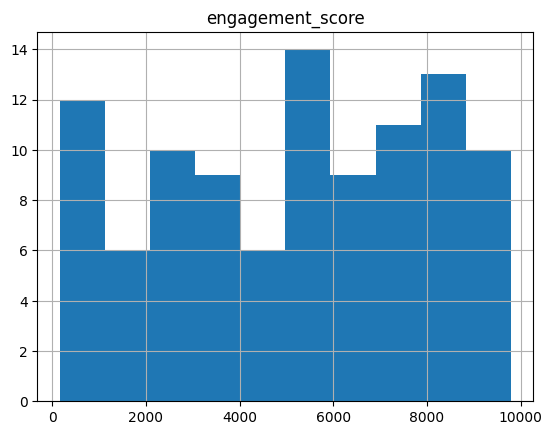

In [99]:
df.hist()
plt.show()

In [100]:
df.corr()

/tmp/ipykernel_3082/1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,engagement_score
engagement_score,1.0


In [101]:
#GEtting data and start organizing it. 

!pip install pytrends
from pytrends.request import TrendReq
pytrends = TrendReq(hl='en-US', tz=360)
keywords=['GenZ fashion', 'GenZ tech', 'GenZ lifestyle', 'GenZ social media']
pytrends.build_payload(['GenZ fashion', 'GenZ tech', 'GenZ lifestyle', 'GenZ social media'], timeframe='today 3-m') #last three months, global
data=pytrends.interest_over_time()

if 'isPartial' in data.columns:
    data= data.drop(columns=['isPartial'])

    
data.to_csv('genz_google_trends.csv', index=True)
print('Data saved!')
print(data.head())
print(df.describe())

Data saved!
            GenZ fashion  GenZ tech  GenZ lifestyle  GenZ social media
date                                                                  
2025-08-27             0          0               0                  0
2025-08-28             0          0               0                  0
2025-08-29             0          0               0                  0
2025-08-30             0          0               0                  0
2025-08-31             0          0               0                  0
       engagement_score
count         100.00000
mean         5208.23000
std          2835.22023
min           164.00000
25%          2774.25000
50%          5491.50000
75%          7673.50000
max          9792.00000


In [10]:
import os
print(os.getcwd())

/mnt/batch/tasks/shared/LS_root/mounts/clusters/ntjanz1/code


In [40]:
!ls -lh


total 52K
drwxrwxrwx 2 root root    0 Nov 23 05:00 Logs
-rwxrwxrwx 1 root root  46K Nov 24 00:06 Untitled.ipynb
drwxrwxrwx 2 root root    0 Nov 23 04:54 Users
-rwxrwxrwx 1 root root 1.9K Nov 23 23:53 genz_google_trends.csv
-rwxrwxrwx 1 root root 1.1K Nov 23 23:41 google_trends.csv
-rwxrwxrwx 1 root root 2.1K Nov 23 23:26 mock_trends.csv


In [41]:
!find /mnt/batch/tasks/shared/LS_root/mounts/clusters/ntjanz1/code -name 'genz_google_trends.csv'

/mnt/batch/tasks/shared/LS_root/mounts/clusters/ntjanz1/code/genz_google_trends.csv


In [103]:
from azureml.core import Workspace, Dataset

ws=Workspace.from_config()
datastore = ws.get_default_datastore()
datastore.upload_files(
    files=['/mnt/batch/tasks/shared/LS_root/mounts/clusters/ntjanz1/code/genz_google_trends.csv'],
    target_path='genz_data/',
    overwrite=True)

#filename='/mnt/batch/tasks/shared/LS_root/mounts/clusters/ntjanz1/code/genz_google_trends.csv'
dataset=Dataset.Tabular.from_delimited_files(path=[(datastore, 'genz_data/genz_google_trends.csv')])
dataset=dataset.register(workspace=ws,
                         name='genz_trends_dataset',
                         description='Google Trends data for GenZ predictor',
                         create_new_version=True)
print('Dataset registered successfully!')

Uploading an estimated of 1 files
Uploading /mnt/batch/tasks/shared/LS_root/mounts/clusters/ntjanz1/code/genz_google_trends.csv
Uploaded /mnt/batch/tasks/shared/LS_root/mounts/clusters/ntjanz1/code/genz_google_trends.csv, 1 files out of an estimated total of 1
Uploaded 1 files
Dataset registered successfully!


In [104]:
###Step 2: Clean data
# Retrieve the dataset by name
dataset = Dataset.get_by_name(ws, name='genz_trends_dataset')

# Convert to pandas DataFrame
df = dataset.to_pandas_dataframe()
print(df.head())



{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe'}
{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe', 'activityApp': 'TabularDataset'}
        date  GenZ fashion  GenZ tech  GenZ lifestyle  GenZ social media
0 2025-08-27             0          0           False                  0
1 2025-08-28             0          0           False                  0
2 2025-08-29             0          0           False                  0
3 2025-08-30             0          0           False                  0
4 2025-08-31             0          0           False                  0


In [105]:

import numpy as np
df = df.replace(0, np.nan).dropna()


In [106]:
print(df.isnull().sum())

date                 0
GenZ fashion         0
GenZ tech            0
GenZ lifestyle       0
GenZ social media    0
dtype: int64


In [107]:
df_long = df.melt(
    id_vars=["date"],                # keep date as identifier
    value_vars=["GenZ fashion","GenZ tech","GenZ lifestyle","GenZ social media"],
    var_name="trend",                # new column name
    value_name="engagement_score"    # values column
)

print(df_long.head())


        date         trend engagement_score
0 2025-11-13  GenZ fashion             16.0
1 2025-11-17  GenZ fashion             16.0
2 2025-11-25  GenZ fashion             15.0
3 2025-11-13     GenZ tech              5.0
4 2025-11-17     GenZ tech              5.0


In [108]:
df['date']=pd.to_datetime(df['date'])

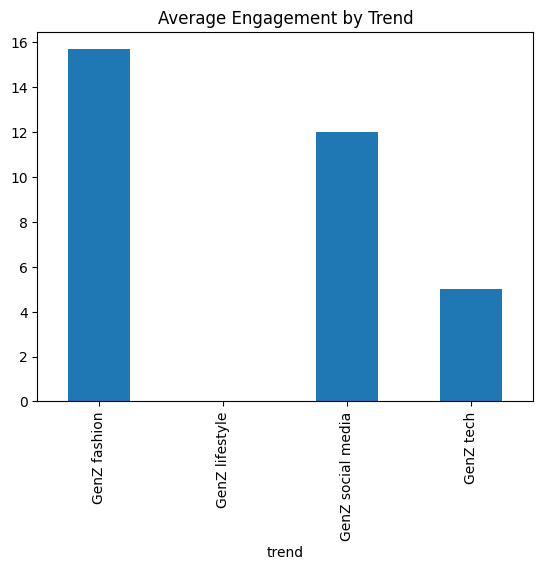

In [109]:
import matplotlib.pyplot as plt

df_long.groupby("trend")["engagement_score"].mean().plot(kind="bar")
plt.title("Average Engagement by Trend")
plt.show()


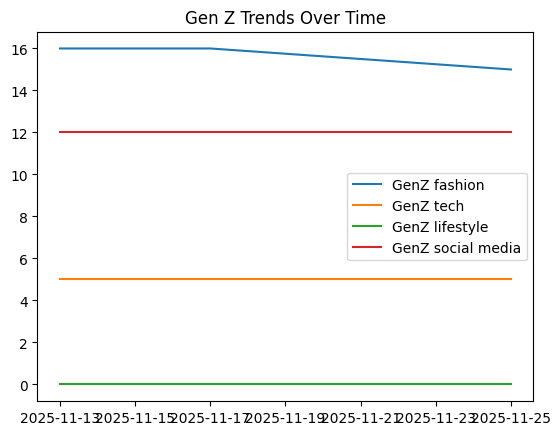

In [110]:
for t in df_long["trend"].unique():
    subset = df_long[df_long["trend"] == t]
    plt.plot(subset["date"], subset["engagement_score"], label=t)

plt.legend()
plt.title("Gen Z Trends Over Time")
plt.show()


In [111]:
import numpy as np

numeric_cols = df.columns[1:]

for col in numeric_cols:
    prev = df[col].shift(1)
    diff = df[col] - prev
    df[f'{col}_growth'] = np.divide(diff, prev, where=prev != 0)
    df.loc[prev == 0, f'{col}_growth'] = np.nan


In [112]:
for col in df.columns[1:]:
    print(col, (df[col].shift(1) == 0).sum(), "prev==0 rows")


GenZ fashion 0 prev==0 rows
GenZ tech 0 prev==0 rows
GenZ lifestyle 2 prev==0 rows
GenZ social media 0 prev==0 rows
GenZ fashion_growth 1 prev==0 rows
GenZ tech_growth 1 prev==0 rows
GenZ lifestyle_growth 0 prev==0 rows
GenZ social media_growth 1 prev==0 rows


In [113]:
df_long = df.melt(
    id_vars=["date"],
    value_vars=["GenZ fashion","GenZ tech","GenZ lifestyle","GenZ social media"],
    var_name="trend",
    value_name="engagement_score"
)
print(df_long.head())


        date         trend engagement_score
0 2025-11-13  GenZ fashion             16.0
1 2025-11-17  GenZ fashion             16.0
2 2025-11-25  GenZ fashion             15.0
3 2025-11-13     GenZ tech              5.0
4 2025-11-17     GenZ tech              5.0


In [114]:
df_growth = df.melt(
    id_vars=["date"],
    value_vars=["GenZ fashion_growth","GenZ tech_growth",
                "GenZ lifestyle_growth","GenZ social media_growth"],
    var_name="trend",
    value_name="growth_rate"
)
print(df_growth.head())


        date                trend growth_rate
0 2025-11-13  GenZ fashion_growth         NaN
1 2025-11-17  GenZ fashion_growth         0.0
2 2025-11-25  GenZ fashion_growth     -0.0625
3 2025-11-13     GenZ tech_growth         NaN
4 2025-11-17     GenZ tech_growth         0.0


In [115]:
# Convert date column to datetime if not already
df["date"] = pd.to_datetime(df["date"])

# Create a new column with weekday names
df["weekday"] = df["date"].dt.day_name()

print(df[["date","weekday"]].head())


         date   weekday
78 2025-11-13  Thursday
82 2025-11-17    Monday
90 2025-11-25   Tuesday


In [116]:
df_long["date"] = pd.to_datetime(df_long["date"])
df_long["weekday"] = df_long["date"].dt.day_name()


In [117]:
weekday_avg = df_long.groupby("weekday")["engagement_score"].mean().reindex(
    ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
)

print(weekday_avg)


weekday
Monday       8.25
Tuesday      8.00
Wednesday     NaN
Thursday     8.25
Friday        NaN
Saturday      NaN
Sunday        NaN
Name: engagement_score, dtype: float64


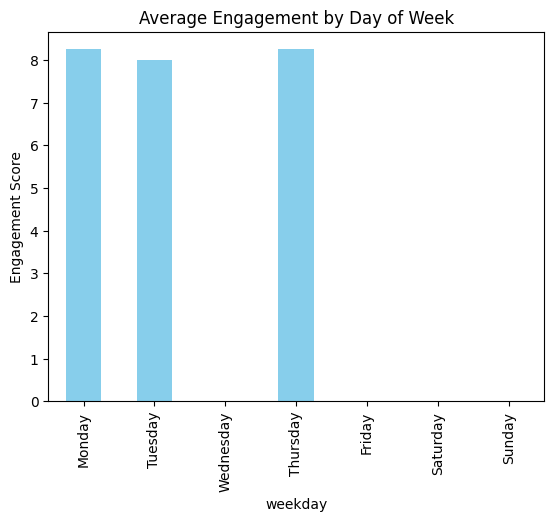

In [118]:
import matplotlib.pyplot as plt

weekday_avg.plot(kind="bar", color="skyblue")
plt.title("Average Engagement by Day of Week")
plt.ylabel("Engagement Score")
plt.show()


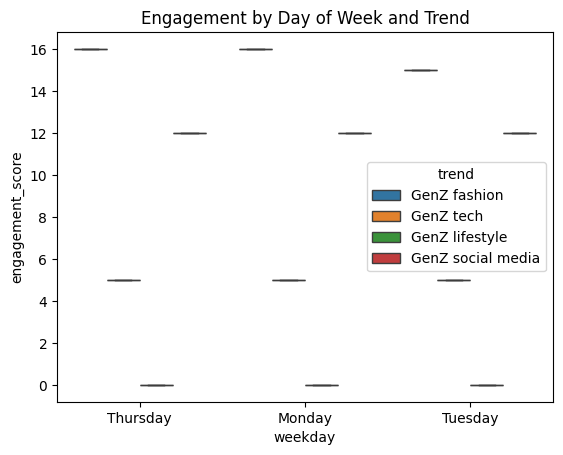

In [119]:
#trend specific analysis
sns.boxplot(x="weekday", y="engagement_score", hue="trend", data=df_long)
plt.title("Engagement by Day of Week and Trend")
plt.show()


In [120]:
df_long["date"] = pd.to_datetime(df_long["date"])
df_long["weekday"] = df_long["date"].dt.day_name()


In [121]:
weekday_trend = (
    df_long.groupby(["weekday","trend"])["engagement_score"]
    .mean()
    .reset_index()
)

# Order weekdays properly
weekday_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
weekday_trend["weekday"] = pd.Categorical(weekday_trend["weekday"], categories=weekday_order, ordered=True)
weekday_trend = weekday_trend.sort_values("weekday")


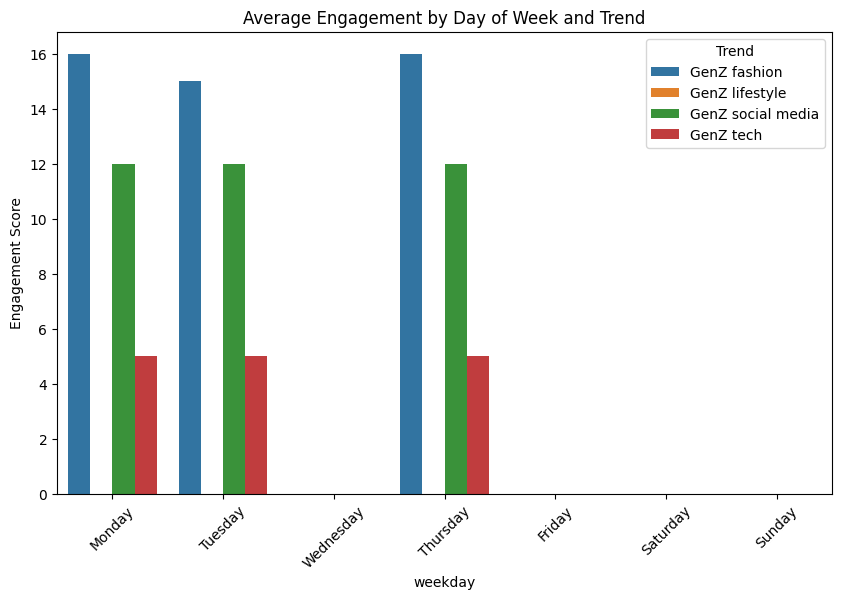

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.barplot(data=weekday_trend, x="weekday", y="engagement_score", hue="trend")
plt.title("Average Engagement by Day of Week and Trend")
plt.ylabel("Engagement Score")
plt.xticks(rotation=45)
plt.legend(title="Trend")
plt.show()


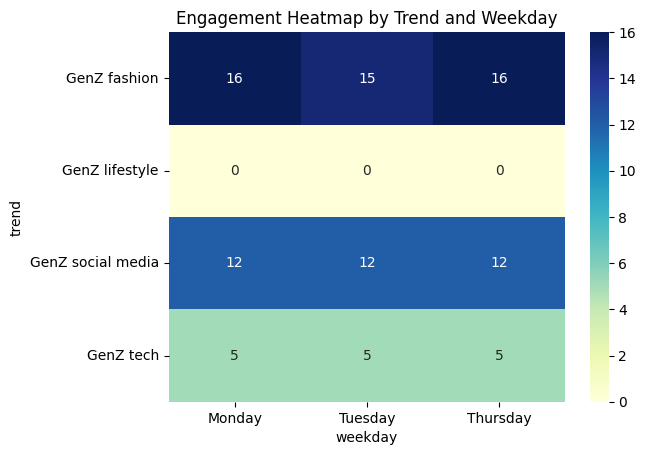

In [123]:
pivot = weekday_trend.pivot(index="trend", columns="weekday", values="engagement_score")
sns.heatmap(pivot, annot=True, cmap="YlGnBu")
plt.title("Engagement Heatmap by Trend and Weekday")
plt.show()


In [124]:
#training a simple model: 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Features: trend and weekday
df_long["date"] = pd.to_datetime(df_long["date"])
df_long["weekday"] = df_long["date"].dt.day_name()

X = pd.get_dummies(df_long[["trend","weekday"]])   # predictors
y = df_long["engagement_score"]                   # target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = RandomForestRegressor()
model.fit(X_train, y_train)

print("Model score:", model.score(X_test, y_test))


Model score: 0.9082137614678899


In [125]:
#saving my model:
import joblib
joblib.dump(model, "genz_predictor.pkl")


['genz_predictor.pkl']

In [126]:
import joblib
model = joblib.load("genz_predictor.pkl")


In [127]:
#checking: 
print(type(model))


<class 'sklearn.ensemble._forest.RandomForestRegressor'>


In [128]:
import os
print(os.listdir())


['.amlignore', '.amlignore.amltmp', '.ipynb_aml_checkpoints', '.ipynb_checkpoints', 'genz-personalization-trend-forecasting', 'genz_google_trends.csv', 'genz_google_trends_processed.csv', 'genz_predictor.pkl', 'Google-data-trends.ipynb', 'google_trends.csv', 'Logs', 'mock_trends.csv', 'outputs', 'Untitled.ipynb', 'untitled.ipynb.amltmp', 'Untitled1.ipynb', 'Users']
